## Deconvolution benchmark
<br>
<b>Description</b> : In this notebook we show the mapping result of Tangram2 on breast cancer dataset. we explicitly show the mapping result for one of the breast cancer sample CID44971, in Figure 4b<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import tangram2 as tg2

/raid/home/huangh83/miniforge3/envs/tangram2/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# --- Data Loading ---
ad_sc = sc.read_h5ad('../../data/original/bc/sc/bc.h5ad')

# Load markers once
#markers = list(pd.read_csv('../../res/marker_genes_BC.txt', index_col=0).index)
sc.tl.rank_genes_groups(ad_sc, groupby="celltype_subset", use_raw=False)
markers_df = pd.DataFrame(ad_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :] #get first 101 genes for each of the 23 subgroups
markers = list(np.unique(markers_df.melt().value.values))

patient_ID = ['CID4290', 'CID4535', 'CID4465', 'CID44971']

In [4]:
# --- Main Processing Loop ---
# Assuming range(3,4) is intentional for running only patient_ID[3] ('CID44971')

ad_map_all = {}
for i in range(3,4):
    ad_sp = sc.read_h5ad('../../data/original/bc/sp/ad_sp_' + patient_ID[i] + '.h5ad')
    # Filter single-cell data based on spatial data subtype
    spatial_subtype = ad_sp.obs['subtype'].values[0]
    
    print(f"cancer subtype: {spatial_subtype}") # Formatted print for clarity
    if spatial_subtype == 'ER':
        ad_sc_mapping = ad_sc[ad_sc.obs['subtype'] == 'ER+'].copy() # .copy() to ensure a writable copy
    elif spatial_subtype == 'TNBC':
        ad_sc_mapping = ad_sc[ad_sc.obs['subtype'] == 'TNBC'].copy()
        
    # start the mapping
    tg2.mapping.pp_adatas(ad_sc_mapping, ad_sp, genes = markers)

    ad_map = tg2.mapping.map_cells_to_space(ad_sc_mapping, ad_sp,
        mode="clusters",
        device='cuda:0',
        cluster_label = 'celltype_subset'
    )
    
    ad_map.obs['celltype_minor'] = [
        ad_sc_mapping[ad_sc_mapping.obs['celltype_subset'] == cs].obs['celltype_minor'].iloc[0]
        for cs in ad_map.obs.celltype_subset
    ]
    ad_map.obs['celltype_major'] = [
        ad_sc_mapping[ad_sc_mapping.obs['celltype_subset'] == cs].obs['celltype_major'].iloc[0]
        for cs in ad_map.obs.celltype_subset
    ]

    ad_map.X = ad_map.X * (ad_map.obs['coefficient'].to_numpy())[:, None]

    ad_map_all[patient_ID[i]] = ad_map


cancer subtype: TNBC


INFO:root:2076 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:16081 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 2076 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.833, KL reg: 4.163, Entropy reg: -10.448
Score: 0.895, KL reg: 3.892, Entropy reg: -8.474
Score: 0.896, KL reg: 3.892, Entropy reg: -8.271
Score: 0.896, KL reg: 3.892, Entropy reg: -8.209
Score: 0.897, KL reg: 3.892, Entropy reg: -8.183
Score: 0.897, KL reg: 3.892, Entropy reg: -8.168
Score: 0.897, KL reg: 3.892, Entropy reg: -8.159
Score: 0.897, KL reg: 3.892, Entropy reg: -8.155
Score: 0.897, KL reg: 3.892, Entropy reg: -8.152
Score: 0.897, KL reg: 3.892, Entropy reg: -8.148


INFO:root:Saving results..


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


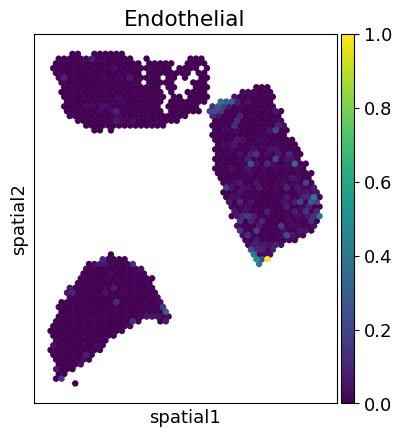

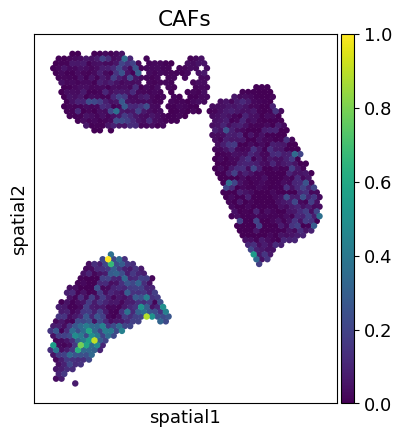

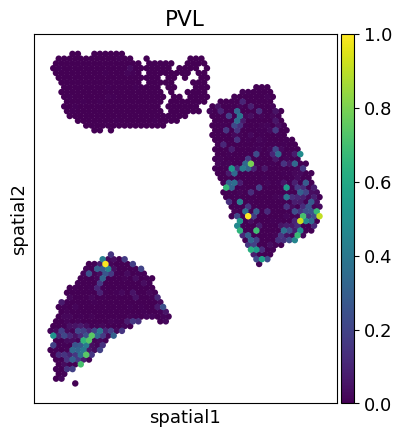

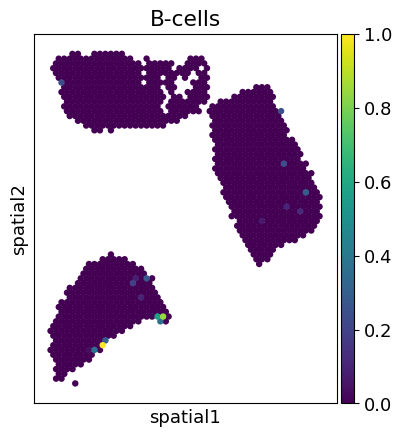

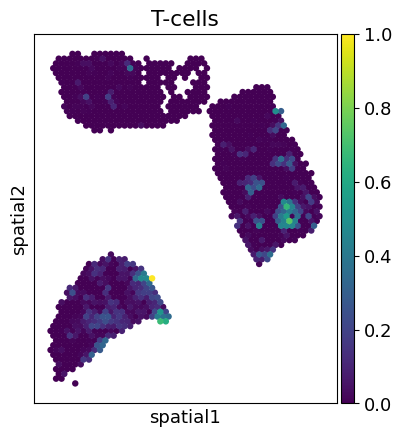

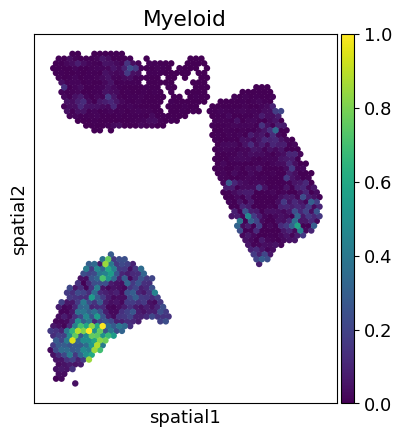

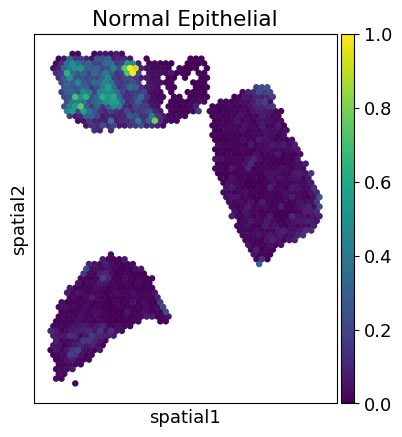

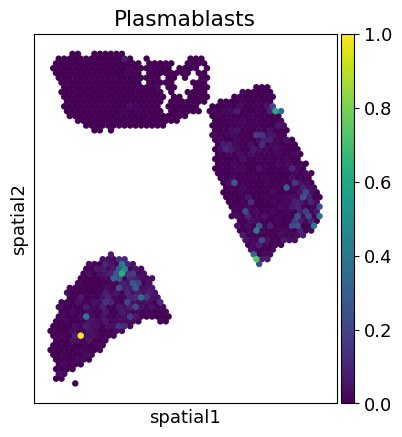

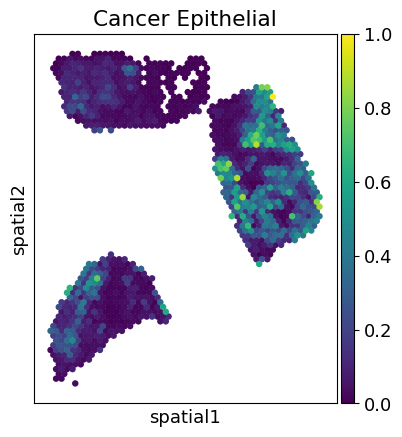

In [5]:
# --- Plotting Section ---
# Assuming ad_map from the last iteration of the loop is intended for plotting

patient = 'CID44971'
if ad_map_all[patient]: # Ensure ad_map_all is not empty
    ad_map_for_plotting = ad_map_all[patient] # Get the last mapped AnnData for plotting
    ad_sp_for_plotting = sc.read_h5ad('../../data/original/bc/sp/ad_sp_' + patient + '.h5ad') # Reload ad_sp for consistent plotting base

    # Project cell annotations for 'celltype_major'
    tg2.mapping.project_cell_annotations(ad_map_for_plotting, ad_sp_for_plotting, annotation='celltype_major')
    annotation_list = list(pd.unique(ad_sc[ad_sc.obs['subtype'] == 'TNBC'].obs['celltype_major'])) # Re-derive annotation_list from the correct ad_sc mapping

    plt.rcParams.update({'font.size': 13})

    for ann_type in annotation_list:
        # Create a DataFrame for plotting from tangram_ct_pred
        # It is crucial NOT to drop columns from ad_sp.obs in a loop that reuses ad_sp.
        # Instead, directly use the relevant data from obsm.
        df_plot_data = ad_sp_for_plotting.obsm["tangram_ct_pred"][[ann_type]]
        tg2.mapping.construct_obs_plot(df_plot_data, ad_sp_for_plotting, perc=0) # Use ad_sp_for_plotting here

        sc.pl.spatial(
            ad_sp_for_plotting, color=[ann_type], cmap="viridis", show=False, img_key=None, size=1.8
        )
        # The commented out savefig indicates saving to file, which should be done explicitly
        # if output files are desired.
        # plt.savefig(f'figure3/{ann_type}.pdf', dpi=300)
        plt.show() # To display each plot in the notebook